<a href="https://colab.research.google.com/github/smkj33/greyscale-image-colourisation/blob/master/Sid_Image_Colorisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports
**Try** to keep Most of the imports in this cell

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader

import torch.optim as optim

import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np

from skimage.transform import resize
import scipy.ndimage.interpolation as sni
from skimage import color, io

# import cv2

from PIL import Image

import time

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Pytorch device: " + str(device))

Pytorch device: cuda:0


# Mount Google Drive

In [2]:
# this saves the model to your own Google Drive
# once you run, you will have to follow a generated link and get the authorization code
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# Hyperparameters

In [0]:
# model parameters
activ = F.relu
# activ = F.sigmoid
minibatch_size = 64

# trainer parameters
n_epochs = 100
lr = 3.16e-4 # initial learning rate, from chuchienshu for Adam optimizer
# lr = 0.01  # DEBUG
# update_rate = 2000  # training will print updates and generate output every n images
update_period = 15 # training will print updates and generate output every n seconds

lr_update_cycle = 20000 * 5  # lr will be decreased by lr_update_ratio every n images
lr_update_ratio = 0.316
min_learning_rate = 1e-8

# output and checkpoint parameters
output_minbatch_idx = 0  # minibatch of output image
output_minbatch_sequence_idx = 0  # image within minibatch to output
checkpoint_save_period = 30 * 60  # checkpoint period in seconds

number_of_workers = 2  # number of workers that will load data. 2 if your system supports it (has problems with old pytorch)

# paths for data storage
path_data = '/content/gdrive/My Drive/DRRA/Data/'
# path_data = "C:\\Users\\John Smith\\Desktop\\DRRA_project\\Data\\"

# path_output = "C:\\Users\\John Smith\\Desktop\\DRRA_project\\Results\\"
path_output = "/content/gdrive/My Drive/DRRA/Output/"

# path_checkpoint = "C:\\Users\\John Smith\\Desktop\\DRRA_project\\Checkpoints\\"
path_checkpoint = "/content/gdrive/My Drive/DRRA/Checkpoints/"

# path_done = "C:\\Users\\John Smith\\Desktop\\DRRA_project\\job_done.pth"
path_done = "/content/gdrive/My Drive/DRRA/job_done.pth"

# path_debug = "C:\\Users\\John Smith\\Desktop\\DRRA_project\\Debug\\"
path_debug = "/content/gdrive/My Drive/DRRA/Debug/"

# torch options
torch.set_printoptions(edgeitems=10)  # widen print output


# Dataset

In [0]:
# Reference: https://stackoverflow.com/questions/57989716/loading-npy-files-as-dataset-for-pytorch
# https://discuss.pytorch.org/t/loading-npy-files-using-torchvision/28481/2
# Imports npy files into tensor data structure
def npy_loader(path, file_name):
    return torch.from_numpy(np.load(path + file_name))

def reconstruct_predicted(image_gray, image_ab):
    '''Reconstruct image from l+ab, convert to rgb uint8
    image_gray (1, 1, 256, 256)
    image_ab (1, 2, 256, 256)
    '''
    image_gray = image_gray.squeeze(0).squeeze(0)
    image_ab = image_ab.squeeze(0).permute((1,2,0))
    img = np.zeros((256, 256, 3))
    img[:, :, 0] = image_gray
    img[:, :, 1:] = image_ab
    img = color.lab2rgb(img)  # (256, 256, 3), float(0., 1.)
    img = img * 255
    img = img.astype('uint8')  # (256, 256, 3), int(0, 255)
    return img

In [0]:
# Import reduced Dataset from torch files
abval = torch.load(path_data + "abval_mushroom.pt")
lval = torch.load(path_data + "lval_mushroom.pt")

In [6]:
# smkj33 NOTE: This needs to be removed since train data is available seperately

# split into training and testing (4:1)
lval_training, lval_testing = lval.split((lval.shape[0] - int(lval.shape[0]/5), int(lval.shape[0]/5)))
abval_training, abval_testing = abval.split((lval.shape[0] - int(lval.shape[0]/5), int(lval.shape[0]/5)))
n_training = len(lval_training)
n_testing = len(lval_testing)
n_training_minibatches = int(n_training / minibatch_size) + 1
n_testing_minibatches = int(n_testing / minibatch_size) + 1

print("Minibatch size: {}".format(minibatch_size))
print("Number training images: {}".format(n_training))
print("Number testing images: {}".format(n_testing))
print("Number training minibatches: {}".format(n_training_minibatches))
print("Number testing minibatches: {}".format(n_testing_minibatches))

Minibatch size: 64
Number training images: 800
Number testing images: 200
Number training minibatches: 13
Number testing minibatches: 4


In [0]:
# Bins for quantized ab color space
points = torch.load(path_data + "points.pth")

In [0]:
class CustomDatasetLAB(Dataset):
    ''' Loads an image from storage (in this case in RAM), converts it to the standardized format '''
    def __init__(self, lval, abval):
        # array of luminances and chrominances
        self.l = lval
        self.ab = abval

    def __len__(self):
        return self.l.shape[0]

    def __getitem__(self, idx):
        img_l = self.l[idx]
        img_ab = self.ab[idx]
        # img_l = resize(img_l, (minibatch_size, 256, 256), preserve_range=True) #TODO: is this even valid? expected (row, cols, chans)
        # img_ab = resize(img_ab, (minibatch_size, 256, 256), preserve_range=True)  #TODO: is this even valid? expected (row, cols, chans)

        # img_l = torch.from_numpy(img_l)
        # img_ab = torch.from_numpu(img_ab)

       
        img_l = img_l.unsqueeze(0).unsqueeze(0).float()
        img_ab = img_ab.permute(2,0,1).unsqueeze(0).float()
        # print(img_l.shape)  # (minibatch_size, 1, 224, 224)
        # print(img_ab.shape)  # (minibatch_size, 224, 224, 2)
        # img_l = F.interpolate(img_l, (256, 256))
        # img_ab = F.interpolate(img_ab, (256, 256))

        # img_l = img_l / 256 * 110
        # img_ab = img_ab - 128
        img = torch.cat((img_l, img_ab), dim=1)
        img = img.squeeze(0)  # (3, 256, 256)
        return img

training_dataset = CustomDatasetLAB(lval_training, abval_training)
testing_dataset = CustomDatasetLAB(lval_testing, abval_testing)

trainloader = DataLoader(training_dataset, batch_size = minibatch_size, shuffle=True, num_workers=number_of_workers, pin_memory=True)
testloader = DataLoader(testing_dataset, batch_size = minibatch_size, shuffle=True, num_workers=number_of_workers, pin_memory=True)


# Preview dataset

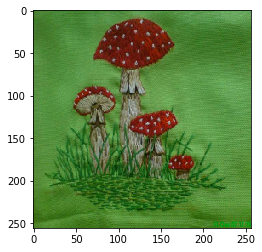

In [12]:
# Preview a single image
# img = training_dataset[0].unsqueeze(0)

dataiter = iter(trainloader)
img = dataiter.next()

l = img[:,0:1,:,:]
ab = img[:,1:,:,:]
l = l[output_minbatch_sequence_idx:output_minbatch_sequence_idx+1]
ab = ab[output_minbatch_sequence_idx:output_minbatch_sequence_idx+1]

# l = lval_training[0]
# ab = abval_training[0]
img = reconstruct_predicted(l.to('cpu'), ab.to('cpu'))
plt.imshow(img)

In [0]:
# Preview a grid of images
# Deprecated

# def show(img):
#     npimg = img.numpy()
#     plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

# l, ab = training_dataset[0]
# lab = torch.cat((l,ab), dim=1).cpu()
# rgb = torch.empty((64, 3, 256, 256))

# for i in range(64):
#     img = lab[i]
#     img = img.permute(1,2,0)
#     img = torch.from_numpy(color.lab2rgb(img))
#     img = img.permute(2,0,1)
#     rgb[i] = img
# show(make_grid(rgb, nrow=16))

# Filter dataset for specific images

In [0]:
# Might be deprecated since DataLoader rewrite

In [0]:
# detect all grayscale and grayish images
# TODO: test is_grayscale with grayscale, debug is_grayish
# def is_grayscale(img):
#     ''' Tests if image is grayscale - all channels of RGB are equal
#     @param img, torch.tensor(3,256,256)
#     @return boolean, true if grayscale
#     '''
#     img = img.byte()
#     ans = (img[0] == img[1]).all() and (img[1] == img[2]).all()
#     return ans

# def is_low_color(img):
#     ''' Tests if an image is of mostly the same color
#     @param img, torch.array(3,256,256)
#     @return boolean, true if image is not too colorful
#     '''
#     tresh = 256 / 10 # within 10% colorization
#     mean = torch.mean(img, dim=0)
#     xy = torch.abs(img[0] - mean)
#     yz = torch.abs(img[1] - mean)
#     zx = torch.abs(img[2] - mean)
#     ans = (xy < tresh).all() and (yz < tresh).all() and (zx < tresh).all()
#     return ans

In [0]:
# Count grayscale and low color images
# grayscale_ct = 0
# low_color_ct = 0
# grayscale = []
# low_color = []

# for m_idx, minibatch in enumerate(training_dataset, 0):
#     l, ab = minibatch
#     lab = torch.cat((l, ab), dim=1).cpu()
#     for i_idx, img in enumerate(lab):
#         if is_grayscale(img):
#             grayscale_ct += 1
#             grayscale.append([m_idx, i_idx])
#         if is_low_color(img):
#             low_color_ct += 1
#             low_color.append([m_idx, i_idx])
# print("Grayscale images: {}, low color images: {}".format(grayscale_ct, low_color_ct))

In [0]:
# Convert all low-colorization images into RGB format and show in a grid
# low_colors = torch.empty((low_color_ct,3,256,256))
# for i, idxs in enumerate(low_color, 0):
#     (m_idx, i_idx) = idxs
#     l, ab = training_dataset[m_idx]
#     lab = torch.cat((l[i_idx], ab[i_idx]), dim=0).cpu()
#     img = lab.permute(1,2,0)
#     img = torch.from_numpy(color.lab2rgb(img))
#     img = img.permute(2,0,1)
#     low_colors[i] = img
# show(make_grid(low_colors, nrow=8))

In [0]:
# Show a single low-color image
# m_idx, i_idx = low_color[12]
# l, ab = training_dataset[m_idx]
# l = l[i_idx].unsqueeze(0)
# ab = ab[i_idx].unsqueeze(0)
# plt.imshow(reconstruct_predicted(l.cpu(), ab.cpu()))

# Colorizer NN

In [0]:
class Net(nn.Module):
    ''' Net parameters as in: https://github.com/richzhang/colorization/blob/master/colorization/models/colorization_deploy_v2.prototxt '''
    def __init__(self):
        super(Net, self).__init__()
        # self.bn0 = nn.BatchNorm2d(1,1).to(device)  # pre normalize the input of the image TODO: effect?

        self.conv1_1 = nn.Conv2d(1, 64, 3, padding=1).to(device)
        self.conv1_2 = nn.Conv2d(64, 64, 3, stride=2, padding=1).to(device)
        self.bn1_2 = nn.BatchNorm2d(64).to(device)

        self.conv2_1 = nn.Conv2d(64, 128, 3, padding=1).to(device)
        self.conv2_2 = nn.Conv2d(128, 128, 3, stride=2, padding=1).to(device)
        self.bn2_2 = nn.BatchNorm2d(128).to(device)

        self.conv3_1 = nn.Conv2d(128, 256, 3, padding=1).to(device)
        self.conv3_2 = nn.Conv2d(256, 256, 3, padding=1).to(device)
        self.conv3_3 = nn.Conv2d(256, 256, 3, 2, padding=1).to(device)
        self.bn3_3 = nn.BatchNorm2d(256).to(device)

        self.conv4_1 = nn.Conv2d(256, 512, 3, padding=1).to(device)
        self.conv4_2 = nn.Conv2d(512, 512, 3, padding=1).to(device)
        self.conv4_3 = nn.Conv2d(512, 512, 3, padding=1).to(device)
        self.bn4_3 = nn.BatchNorm2d(512).to(device)

        self.conv5_1 = nn.Conv2d(512, 512, 3, padding=2, dilation=2).to(device)
        self.conv5_2 = nn.Conv2d(512, 512, 3, padding=2, dilation=2).to(device)
        self.conv5_3 = nn.Conv2d(512, 512, 3, padding=2, dilation=2).to(device)
        self.bn5_3 = nn.BatchNorm2d(512).to(device)

        self.conv6_1 = nn.Conv2d(512, 512, 3, padding=2, dilation=2).to(device)
        self.conv6_2 = nn.Conv2d(512, 512, 3, padding=2, dilation=2).to(device)
        self.conv6_3 = nn.Conv2d(512, 512, 3, padding=2, dilation=2).to(device)
        self.bn6_3 = nn.BatchNorm2d(512).to(device)
       
        self.conv7_1 = nn.Conv2d(512, 512, 3, padding=1, dilation=1).to(device)
        self.conv7_2 = nn.Conv2d(512, 512, 3, padding=1, dilation=1).to(device)
        self.conv7_3 = nn.Conv2d(512, 512, 3, padding=1, dilation=1).to(device)
        self.bn7_3 = nn.BatchNorm2d(512).to(device)

        # TODO: what is deconvolution?
        self.conv8_1 = nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1, dilation=1).to(device)
        self.conv8_2 = nn.Conv2d(256, 256, 3, padding=1, dilation=1).to(device)
        self.conv8_3 = nn.Conv2d(256, 256, 3, padding=1, dilation=1).to(device)
        
        self.conv8_313 = nn.Conv2d(256, 313, kernel_size=1).to(device)
        self.softmax = nn.Softmax(dim=1).to(device)

    def forward(self, x):
        ''' expects l tensor[1,1,256,256] '''
        # x = self.bn0(x)
        x = self.bn1_2(activ(self.conv1_2(activ(self.conv1_1(x)))))
        x = self.bn2_2(activ(self.conv2_2(activ(self.conv2_1(x)))))
        x = self.bn3_3(activ(self.conv3_3(activ(self.conv3_2(activ(self.conv3_1(x)))))))
        x = self.bn4_3(activ(self.conv4_3(activ(self.conv4_2(activ(self.conv4_1(x)))))))
        x = self.bn5_3(activ(self.conv5_3(activ(self.conv5_2(activ(self.conv5_1(x)))))))
        x = self.bn6_3(activ(self.conv6_3(activ(self.conv6_2(activ(self.conv6_1(x)))))))
        x = self.bn7_3(activ(self.conv7_3(activ(self.conv7_2(activ(self.conv7_1(x)))))))
        x = activ(self.conv8_3(activ(self.conv8_2(activ(self.conv8_1(x))))))
        z_hat = self.softmax(self.conv8_313(x))
        return z_hat

# Colorizer functions

In [0]:
def get_index(ab):
    ''' Quantize image and return bin-number for whole h*w
    @param: in_data - torch.tensor (minibatch_size,2,h,w)
    @return: idx_bin - torch.tensor (minibatch_size,h,w)
     '''
    ab = ab.unsqueeze(1) # make dimension for z broadcasting (1,1,2,64,64)
    points_reshaped = points.unsqueeze(0).unsqueeze(-1).unsqueeze(-1)  # (1, 313, 2, 1, 1)
    distance = (ab - points_reshaped)**2 # (1, 313, 2, 64, 64)
    avg_distance = torch.mean(distance, dim = 2) # (1, 313, 64, 64) n.b. closest bin is (a_dist + b_dist)/2
    bin_idx = avg_distance.argmin(dim = 1)  # (1, 64, 64)
    # print(bin_idx.shape)
    return bin_idx

def get_index_top5(ab):
    ''' Quantize image and return top5 bin-numbers and their relative probs for whole h*w
    @param: in_data - torch.tensor (minibatch_size,2,h,w)
    @return: idx_bin - torch.tensor (minibatch_size,5,h,w),  torch.tensor (minibatch_size,5,h,w)
     '''
    # TODO: currently the probabilities are inversly proportional to distances. Should be "weighed using Gauss kernel"
    ab = ab.unsqueeze(1) # make dimension for z broadcasting (1,1,2,64,64)
    points_reshaped = points.unsqueeze(0).unsqueeze(-1).unsqueeze(-1)  # (1, 313, 2, 1, 1)
    distance = (ab - points_reshaped)**2 # (1, 313, 2, 64, 64)
    avg_distance = torch.mean(distance, dim = 2) # (1, 313, 64, 64) n.b. closest bin is (a_dist + b_dist)/2
    bin_vals, bin_idx = avg_distance.sort(dim = 1) # (1, 313, 64, 64)
    bin_weights = bin_vals[0,0,:,:] / (bin_vals[:, 0:5, :, :] + 1e-8)  # normalize and inverse probabilities
    bin_idx = bin_idx[:, 0:5, :, :]
    return bin_idx, bin_weights

def get_distances(ab):
    ''' Quantize image and return top5 bin-numbers and their relative probs for whole h*w
    @param: in_data - torch.tensor (minibatch_size,2,h,w)
    @return: distances - torch.tensor (minibatch_size, 313, h, w)
     '''
    # TODO: currently the probabilities are inversly proportional to distances. Should be "weighed using Gauss kernel"
    ab = ab.unsqueeze(1) # make dimension for z broadcasting (1,1,2,64,64)
    points_reshaped = points.unsqueeze(0).unsqueeze(-1).unsqueeze(-1)  # (1, 313, 2, 1, 1)
    distance = (ab - points_reshaped)**2 # (1, 313, 2, 64, 64)
    avg_distance = torch.mean(distance, dim = 2) # (1, 313, 64, 64) n.b. closest bin is (a_dist + b_dist)/2
    # bin_vals, bin_idx = avg_distance.sort(dim = 1) # (1, 313, 64, 64)
    # bin_weights = bin_vals[0,0,:,:] / (bin_vals[:, 0:5, :, :] + 1e-8)  # normalize and inverse probabilities
    # bin_idx = bin_idx[:, 0:5, :, :]
    return avg_distance

# NOTE: This is the one-hot encoded version
def h_inverse(ab):
    ''' construct z tensor given ab ground truth. Hard encoded.
    @param ab, tensor([minibatch_size, 64,64,2])
    @return z, tensor[minibatch_size,64,64,313]
    '''
    ab_idx = get_index(ab)
    z = F.one_hot(ab_idx, 313).float()
    return z

def h_inverse_top5(ab):
    # Note: the output of this function does not match h_inverse_top5_optim
    ''' construct z tensor given ab ground truth. Soft encoded (top5 weighted probabilities)
    @param ab, tensor([minibatch_size,64,64,2])
    @return z, tensor[minibatch_size, 64,64,313]
    '''

    n = ab.shape[0]
    h = ab.shape[2]
    w = ab.shape[3]

    def col_wise_replace(dest, idxs, source):
        for k in range(n):
            for i in range(h):
                for j in range(w):
                    dest[k,i,j].index_copy_(0, idxs[k,i,j], source[k,i,j])

    # print(ab.device)
    # print(ab.shape)  #(minibatch_size, 2, 64, 64)
    idxs, probs = get_index_top5(ab)
    # print(idxs.shape, probs.shape)
    idxs = idxs.permute(0,2,3,1)  # (minibatch_size, 64, 64, 5)
    probs = probs.permute(0,2,3,1)  # (minibatch_size, 64, 64, 5)
    probs = probs.softmax(3)

    z = torch.zeros((idxs.shape[0], 64, 64, 313), dtype=torch.float32, device=device)
    col_wise_replace(z, idxs, probs)
    return z

def H(z_hat):
    """
    Input: Z_hat (1,313,64,64)
     - 313 probablities for each of the H * W pixels.
      This is for 313 quantised a-b bins

    Output: Y_hat (64, 64, 2)
    - ab value matrix
    """
    z_hat_softmax = f_t(z_hat)
    z_hat_softmax = z_hat_softmax.squeeze(0).permute(1,2,0) # remove singleton dimension 0
    # print(z_hat_softmax.shape) # [64,64,313]
    a_bins = points[:,0].unsqueeze(0).unsqueeze(0)
    b_bins = points[:,1].unsqueeze(0).unsqueeze(0)
    # print(b_bins.shape)  # [1,1,313]
    a_hat = (z_hat_softmax * a_bins).sum(2)
    b_hat = (z_hat_softmax * b_bins).sum(2)
    a_hat = a_hat.unsqueeze(0)
    b_hat = b_hat.unsqueeze(0)
    # print(a_hat.shape)  # [1, 64, 64]
    ab_hat = torch.cat((a_hat, b_hat), 0)
    # print(ab_hat.shape) # [2, 64, 64]
    return ab_hat.permute(1,2,0)

def f_t(z_hat):
    """
    f_t function in equation 5 
    input Z_hat has dimensions (1, 313, 64, 64)
    ??? output f_t_Z dimension H * W * Q

    - Each of the 313 Q probability values of each H * W pixels is converted to 
      softmax probabilites.

    - The final value is the expected value of all these 313 softmax probablities across the color bins
      this is calculated in the H function
    """
    T = 0.38 # From page 6 of paper
    z_hat_exp = torch.exp(torch.log(z_hat)/T) # dimension: H * W * Q

    deno = torch.sum(z_hat_exp, dim = 1)
    z_hat_softmax = z_hat_exp / deno 
    return z_hat_softmax

def adjust_learning_rate(optimizer):
    """ Sources - training VGGbn-16: https://github.com/pytorch/examples/blob/master/imagenet/main.py, https://github.com/chuchienshu/Colorization/blob/master/solver.py"""
    
    global_lr = optimizer.param_groups[0]['lr']
    if global_lr > min_learning_rate:
        global_lr = global_lr * (lr_update_ratio)
    for param_group in optimizer.param_groups:
        param_group['lr'] = global_lr
    
def generate_test_output():
    img = training_dataset[0].cuda().unsqueeze(0)
    l = img[:,0:1,:,:]
    ab = img[:,1:,:,:]       
    z_hat = net(l)
    ab_hat = H(z_hat)
    ab_hat = ab_hat.permute(2,0,1).unsqueeze(0)
    ab_hat_256 = F.interpolate(ab_hat, (256, 256))
    img_rgb = reconstruct_predicted(l.cpu(), ab_hat_256.detach().cpu())
    img = Image.fromarray(img_rgb)
    img.save(path_output + "colorized_image{}_{}.png".format(epoch, i))
    print("       Colorization preview saved.")

# Cleanup output and checkpoints 

In [0]:
!rm -rf "$path_output"
!mkdir "$path_output"
!rm -rf "$path_checkpoint"
!mkdir "$path_checkpoint"
!rm -rf "$path_debug"
!mkdir "$path_debug"
print("/Output, /Checkpoints, /Debug cleaned up.")
# print("/Output, /Debug cleaned up.")

/Output, /Checkpoints, /Debug cleaned up.


# Init net, optimizer, loss



In [0]:
net = Net()
net.to(device)

class OutCrossEntropyLoss(torch.nn.Module):
    def __init__(self):
        super(OutCrossEntropyLoss,self).__init__()
        
    def forward(self,z,z_hat):
        # TODO: shape equals?
        z_hat = z_hat + 1e-08  # small epsilon to avoid log(0) error
        mul = z.mul(z_hat.log())
        MSE = mul.sum()
        loss = -MSE / (z.shape[2] * z.shape[3] * z.shape[0])  # loss normalized to number pixels and minibatch size
        return loss 

criterion = OutCrossEntropyLoss()  # Cross Entropy Loss
criterion.to(device)
# optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=1e-3, betas=(0.8, 0.9))
resume_epoch = 0

losses = []

**bold text**# Load net, optimizer

In [0]:
# load_epoch = 0
# load_minibatch = 34

# net = Net()
# net.load_state_dict(torch.load(path_checkpoint + "checkpoint_model_{}_{}.pth".format(load_epoch, load_minibatch)))

# loaded_optimizer = optim.Adam(net.parameters(), lr=lr)
# loaded_optimizer.load_state_dict(torch.load(path_checkpoint + "checkpoint_optim_{}_{}.pth".format(load_epoch, load_minibatch)))
# loaded_lr = loaded_optimizer.param_groups[0]["lr"]
# net.to(device)
# for param_group in optimizer.param_groups:
#         param_group['lr'] = loaded_lr
# print("Set optimizer lr = {}".format(optimizer.param_groups[0]["lr"]))
# resume_epoch = load_epoch + 1

In [0]:
# Resume from epoch
# resume_epoch = 9

# Train

In [0]:
print("Started training from epoch {}. Minibatch size = {}, number of samples per epoch = {}".format(resume_epoch, minibatch_size, n_training))
print("-"*100)

# DEBUG: save parameters before update
# with open(path_debug + "init_net_parameters.txt", "w") as f:
#     for param_group in net.parameters():
#         f.write(str(param_group))

last_checkpoint = time.time()
last_update = time.time()
lr_update_counter = 0

class JobDone( Exception ):
    pass
try:
    for epoch in range(resume_epoch, n_epochs):  # resume from next epoch
        epoch_loss = 0
        epoch_start = time.time()

        for i, img in enumerate(trainloader, 0):
            img = img.cuda()
            l = img[:,0:1,:,:]
            ab = img[:,1:,:,:] 

            # DEBUG uncomment
            #Adjust learning rate for this epoch
            # if lr_update_counter // lr_update_cycle > 0:
            #       adjust_learning_rate(optimizer)
            #       lr_update_counter = 0
                  

            # DEBUG: save parameters before update
            # with open(path_debug + "previous_net_parameters_{}_{}.txt".format(epoch, i), "w") as f:
            #         for param_group in net.parameters():
            #             f.write(str(param_group)) 

            # DEBUG: all unique colors in the image, deprecated
            # print(np.unique(get_index(ab_64).flatten()).tolist())

            ab_64 = F.interpolate(ab, (64,64))
            # z = h_inverse(ab_64) # (minibatch_size, 64, 64, 313) - 1-hot
            z = h_inverse(ab_64) # (minibatch_size, 64, 64, 313) - soft encoded
            z = z.permute(0,3,1,2)  # (minibatch_size, 313, 64, 64)
            optimizer.zero_grad()
            z_hat = net(l)
            loss = criterion(z, z_hat)  # our cross entropy loss
            loss.backward()

            # DEBUG: loss calculation NaN
            # torch.save(z_hat, path_debug + "z_hat_{}_{}.pth".format(epoch, i))
            # torch.save(z, path_debug + "z_{}_{}.pth".format(epoch, i))

            # DEBUG: save gradients
            # with open(path_debug + "parameter_gradients_{}_{}.txt".format(epoch, i), "w") as f:
            #         for param_group in net.parameters():
            #             f.write(str(param_group.grad))
            
            optimizer.step()

            # DEBUG: parameters after update
            # with open(path_debug + "net_parameters_{}_{}.txt".format(epoch, i), "w") as f:
            #             for param_group in net.parameters():
            #                 f.write(str(param_group))       

            lr_update_counter = lr_update_counter + minibatch_size
            losses.append(loss.item())
            epoch_loss += loss.item()

            # print results every n images 
            # note: (works only if update_rate < epoch size)
            # if (i % int(update_rate/minibatch_size) == 0 and i != 0  
                # and l.shape[0] == minibatch_size):
            
            # print updates every n s
            current_time = time.time()
            if (current_time - last_update) > (update_period):  # save every n seconds
                last_update = time.time()

                print('Epoch {}/{}, minibatch {}/{}, loss {:.4f}, lr = {:.6f}'.format(epoch, n_epochs, i, n_training_minibatches, loss.item(), optimizer.param_groups[0]['lr']))
                # generate_test_output()
            
            # DEBUG uncomment
            # save checkpoint every 10mins
            if (current_time - last_checkpoint) > (checkpoint_save_period):  # save every 10 mins
                last_checkpoint = time.time()
                torch.save(net.state_dict(), path_checkpoint + "checkpoint_model_{}_{}.pth".format(epoch, i))
                torch.save(optimizer.state_dict(), path_checkpoint + "checkpoint_optim_{}_{}.pth".format(epoch, i))
                torch.save(losses, path_checkpoint + "checkpoint_losses_{}_{}.pth".format(epoch, i))
                print("       Checkpoint saved.")

            # DEBUG uncomment
            # catch NaN errors
            # for param_group in net.parameters():
            #     if (torch.isnan(param_group)).any():
            #         print("NaN error in epoch {}, minibatch {}".format(epoch, i))  
            #         raise ValueError("ERROR: One of the predicted values is NaN, aborting.")

            # DEBUG uncomment
            # check if training complete
            # if loss.item() < 0.01 and l.shape[0] == minibatch_size:  # prevent small loss due to remainder minibatch at the end of epoch
            #     print("Loss at job completion: {}".format(loss.item()))
            #     raise JobDone
        
        epoch_finish = time.time()
        epoch_training_duration = (epoch_finish - epoch_start) / 60
        
        # # Save checkpoint
        # torch.save(net.state_dict(), path_checkpoint + "checkpoint_model_{}_{}.pth".format(epoch, i))
        # torch.save(optimizer.state_dict(), path_checkpoint + "checkpoint_optim_{}_{}.pth".format(epoch, i))
        # torch.save(losses, path_checkpoint + "checkpoint_losses_{}_{}.pth".format(epoch, i))
        print("       Checkpoint saved.")

        print("Average epoch loss: {}, took {:.2f} mins to compute.".format(epoch_loss / n_training_minibatches, epoch_training_duration))
        # generate_test_output()


except JobDone:   
    print('Finished Training')
    torch.save(net.state_dict(), path_done)
    print("       Job saved.")

Started training from epoch 0. Minibatch size = 64, number of samples per epoch = 80
----------------------------------------------------------------------------------------------------


RuntimeError: ignored

In [0]:
# EFFICIENCY (Benchmarks 160220):

# n.b. don't use time.time() to measure <1s time intervals (e.g. minibatch processing time), its imprecise.

# epoch rate (min/epoch):
# Reduced dataset - 0.18 min/epoch (for all epochs, regardless of s/img rate)
# Reduced dataset (80 img/epoch): 0.18 min/epoch / 80 img/epoch = 0.0225 min/img = 0.135s/img = 7.4 img/s
# Full dataset (20000 img/epoch): 45 min/epoch / 20000 img/epoch = 0.0225 min/img = 0.135s/img = 7.4 img/s



# Efficiency comparison
Colab card is Tesla K80. It's about 1/4 speed of 1080Ti. Our network is based on VGG-8 architecture

*   Ideally, we should expect about 1/4 of 1080Ti performance according to this chart (~35 img/s).
*   That's in the same order of magnitude as our 7.4 img/s (given extra work our colorizer does).



![alt text](https://drive.google.com/uc?id=1hqUchChMx-lY_LsYMOBlppRHkupSUiK9)

Training duration and scope
*  VGG-16 was trained on ImageNet subset with ~1000img x 1000 categories = 1 000 000 images.
*   List item



#Displaying trained Colorizer results

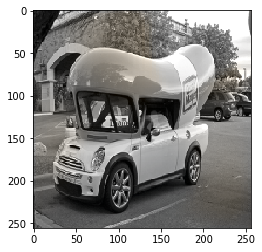

In [0]:
# Test with random image from end of dataset
from random import seed
from random import randint

dataiter_test = iter(trainloader)
img = dataiter_test.next().cuda()
l = img[0:1:,0:1,:,:]
ab = img[0:1:,1:,:,:]
z_hat = net(l)
ab_hat = H(z_hat)
ab_hat = ab_hat.permute(2,0,1).unsqueeze(0)
ab_hat_256 = F.interpolate(ab_hat, (256, 256))
img_rgb = reconstruct_predicted(l.cpu(), ab_hat_256.detach().cpu())
plt.imshow(img_rgb)

# Debug

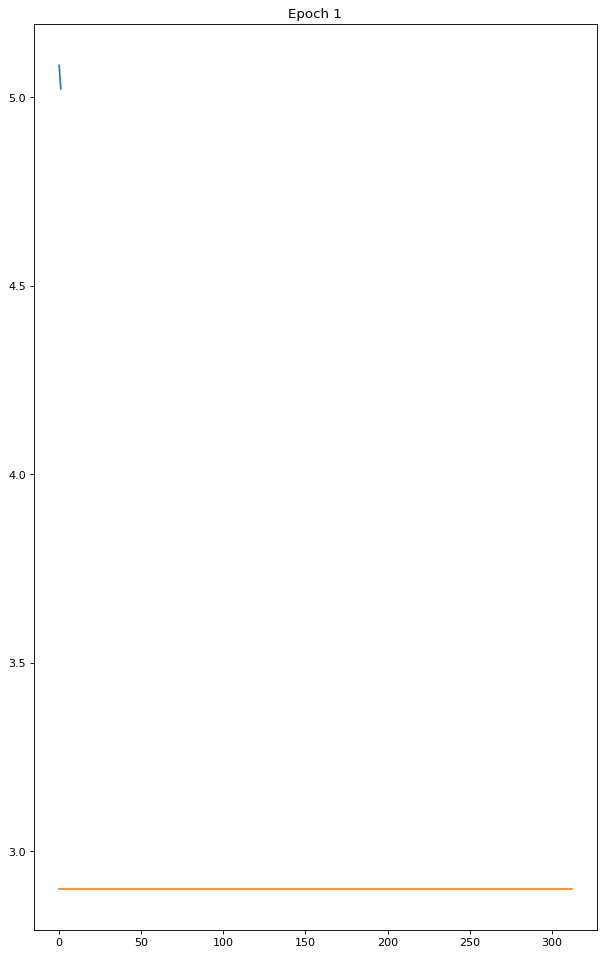

In [0]:
# Load losses file
losses = torch.load(path_checkpoint + "checkpoint_losses_{}_{}.pth".format(0, 1))
load_epoch = 0

# Display losses in subplots split by segment
# Bug: if you don't set bias to False it will instantiate to random number (contents at the location of memory)
# Thus result will be offset by random amount!
window_size = 1
conv = nn.Conv1d(1, 1, kernel_size = window_size, bias=False)
kernel_weights = np.array([1.0 for i in range(window_size)])/window_size
conv.weight.data = torch.FloatTensor(kernel_weights).view(1, 1, window_size)
segment_length = 313

losses1 = torch.tensor(losses).unsqueeze(0).unsqueeze(0)
losses1 = conv(losses1)  # apply running mean
losses1 = losses1.squeeze(0).squeeze(0)
losses_segments1 = torch.split(losses1, segment_length)

subplots = []
n_cols = 2
n_rows = (len(losses_segments1) / n_cols) + 1

fig = plt.figure(num=None, figsize=(20, 15), dpi=80, facecolor='w', edgecolor='k')
for i, segment_loss in enumerate(losses_segments1, 1):
    epoch_idx = load_epoch + i
    segment_loss = segment_loss.detach()
    ax = plt.subplot(n_rows, n_cols, i)
    plt.plot(segment_loss.clone().numpy())
    plt.plot([2.9 for i in range(segment_length)])
    ax.title.set_text('Epoch {}'.format(epoch_idx))

fig.show()
fig.savefig(path_debug + "losses_till_epoch_{}".format(epoch))

In [0]:
# Plot points color bins
pointslist = points.tolist()
lab = torch.zeros((1,1,3))

plt.figure(figsize=(10,10))

for point in pointslist:
    lab[0,0,0] = 50
    lab[0,0,1] = point[0]
    lab[0,0,2] = point[1]
    rgb = color.lab2rgb(lab)
    plt.scatter(point[1], point[0], c=rgb[0], marker='s', s=650)

plt.xlim(-110,110)
plt.ylim(-110,110)
plt.gca().invert_yaxis()
plt.rc('grid', linestyle=":", color='grey')
plt.grid(True)

plt.show()

In [0]:
# # Check cuda memory usage
# torch.cuda.empty_cache() # only empties memory not in use by tensor
# with open(path_debug + "cuda_report.txt", "w") as  f:
#   f.write(torch.cuda.memory_summary())

In [0]:
# # Calculate image seek time
# start = time.time()
# for i in range(int(int(lval.shape[0]/2) / minibatch_size)):
#     training_dataset[i]
# stop = time.time()
# print("{} image seeks took {}s.".format(int(lval.shape[0]/2), stop - start))  # 0.025s, much better than using skimage.resize()

# TODO

In [0]:
# Why is optim after loading so small (800bytes etc)
#    - Test: run from init (~200mb), stop, load from file --> ~ ~200mb, OK!
# TODO: add v(.) coefficient to the loss function (color rarity rebalancing term)
# TODO: optimal minibatch size? Passing minibatch of 32 images to the network? Does not seem to be faster, but sometimes it does.
# TODO: batch norm in beginning of NN required? Effect?
# TODO: did the colorize quality improve after I was experimenting with removing update/render? And now it just got worse (red red red --> grayscale) I saw various colors then.
#     - Am I in a local minimums every time and had a lucky initialization?
# TODO: should I find better init weights?
# TODO: z getting out of range. I should cap the possible values of the output somehow.

# QUESTIONS

In [0]:
# 1. If you fit model on 10 pictures, can you fit worse on those 10 pictures taken alone than when training on 100 pictures? That is, can I underfit by having a limited training data?
# 2. Does loss size matter to training? Do I need larger learning rate if my loss size is small?
# 3. What fixed my model? Most likely dataset fixes, but why?
# 4. What would poor quality dataset (some grayscales, low contrast) affect the training - possible optimal loss? training rate? What other parameters may affect the training rate.

# NOTES

In [0]:
# TODO Dataloader errors. See https://pytorch.org/docs/stable/data.html for Windows error under Platform specific behaviors.

# TODO debug


In [0]:
# 1. Conceptual problems:
#   - Gaussian Kernel application in h_inverse.
#   - converting between distances to bins and probabilities.
# 2. Implementation problems (need unit tests)
#   - h_inverse, 
#   - h_inverse_top5, h_inverse_top5_optim
# 3. Not yet implemented - v() weights.


# Found bugs:
# h_inverse_top5_optim has a bug (black pixels).
# h_inverse_top5 doesn't have a bug! WHY?

